# 0. Import useful packages

In [2]:
import numpy as np
import pandas as pd
import re
import json
import warnings
from matplotlib import pyplot as plt
from my_utils import create_DataFrame, load_data
from user_agents import parse
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# 1. Data exploration

In [3]:
# load the raw dataset
df = create_DataFrame(csv_path='output.log')
df

Skipping line 601729: Expected 7 fields in line 601729, saw 23. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.


,ip,time,method,status_code,path,response_length,user_agent,response_time
0,207.213.193.143,2021-05-12 05:06:00+04:30,Get,304,cdn/profiles/1026106239,0,Googlebot-Image/1.0,32.0
1,207.213.193.143,2021-05-12 05:06:00+04:30,Get,304,images/badge.png,0,Googlebot-Image/1.0,4.0
2,35.110.222.153,2021-05-12 05:06:00+04:30,Get,200,pages/630180847,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32.0
3,35.108.208.99,2021-05-12 05:06:00+04:30,Get,200,images/fav_icon2.ico,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20.0
4,35.110.222.153,2021-05-12 05:06:00+04:30,Get,200,images/sanjagh_logo_purpule5.png,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8.0
...,...,...,...,...,...,...,...,...
1260028,35.117.86.75,2021-05-12 15:08:59+04:30,Get,304,images/graystar_min.png,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4.0
1260029,35.117.86.75,2021-05-12 15:08:59+04:30,Get,304,fonts/sanjagh_icon_font_5.woff,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4.0
1260030,153.126.251.199,2021-05-12 15:08:59+04:30,Get,101,api/v2/connect/215865643,0,okhttp/3.12.1,60003.0
1260031,207.213.207.102,2021-05-12 15:08:59+04:30,Get,304,cdn/profiles/1289255230,0,Googlebot-Image/1.0,20.0


In [7]:
df.isna().sum()

ip                 18090
time                   0
method                 0
status_code            0
path                   0
response_length        0
user_agent             0
response_time      19808
dtype: int64

All the records with NaN value for *ip* have **kube-probe/1.21** as their user_agent. Their *response_time* are also NaN.

These records must be droped from the dataframe.

In [8]:
df[df["ip"].isna()]

,ip,time,method,status_code,path,response_length,user_agent,response_time
25,NaN,2021-05-12 05:06:01+04:30,Get,301,,169,kube-probe/1.21,NaN
85,NaN,2021-05-12 05:06:03+04:30,Get,301,,169,kube-probe/1.21,NaN
145,NaN,2021-05-12 05:06:05+04:30,Get,301,,169,kube-probe/1.21,NaN
175,NaN,2021-05-12 05:06:07+04:30,Get,301,,169,kube-probe/1.21,NaN
215,NaN,2021-05-12 05:06:09+04:30,Get,301,,169,kube-probe/1.21,NaN
...,...,...,...,...,...,...,...,...
1259777,NaN,2021-05-12 15:08:51+04:30,Get,301,,169,kube-probe/1.21,NaN
1259831,NaN,2021-05-12 15:08:53+04:30,Get,301,,169,kube-probe/1.21,NaN
1259900,NaN,2021-05-12 15:08:55+04:30,Get,301,,169,kube-probe/1.21,NaN
1259949,NaN,2021-05-12 15:08:57+04:30,Get,301,,169,kube-probe/1.21,NaN


In [9]:
df.drop(df[df['ip'].isna()].index, inplace = True)

Other NaN values for *response_time* are **mostly** corresponded to **bots**. We fill the NaN values for *response_time* with zero values because they are the requests which gateways respondes to them.

In [10]:
df[df["response_time"].isna()]

,ip,time,method,status_code,path,response_length,user_agent,response_time
776,20.62.177.11,2021-05-12 05:06:31+04:30,Get,200,pros/1993352776,53479,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
2010,20.62.177.60,2021-05-12 05:07:27+04:30,Get,200,pros/1797822247,55330,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
2708,20.62.177.133,2021-05-12 05:08:04+04:30,Get,200,pros/763244865,20947,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
2866,207.213.193.118,2021-05-12 05:08:18+04:30,Get,301,pages/1939232229,169,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,NaN
3468,20.62.177.4,2021-05-12 05:08:49+04:30,Get,200,pros/2084824811,37060,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
...,...,...,...,...,...,...,...,...
1257191,20.62.177.11,2021-05-12 15:07:34+04:30,Get,200,pros/1644096504,24540,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
1257984,20.62.177.11,2021-05-12 15:07:59+04:30,Get,200,pros/743056796,36129,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
1258077,20.62.177.161,2021-05-12 15:08:02+04:30,Get,200,pros/1177343248,51334,Mozilla/5.0 (compatible; SemrushBot/7~bl; +htt...,NaN
1258454,207.213.207.17,2021-05-12 15:08:12+04:30,Get,301,services/1404674245,169,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...,NaN


In [11]:
df['response_time'] = df['response_time'].fillna(0)

In [12]:
df.isna().sum()

ip                 0
time               0
method             0
status_code        0
path               0
response_length    0
user_agent         0
response_time      0
dtype: int64

Now we do not have any NaN values in the DataFrame. But there are some records having null values as their type. For instance,
 
1. "" values for *path* column

In [13]:
df[df["path"] == ""]

,ip,time,method,status_code,path,response_length,user_agent,response_time
155,20.117.146.75,2021-05-12 05:06:06+04:30,Get,307,,0,Go-http-client/2.0,4.0
360,20.92.247.170,2021-05-12 05:06:13+04:30,Get,307,,0,Go-http-client/2.0,8.0
622,76.212.164.3,2021-05-12 05:06:24+04:30,Get,307,,0,Go-http-client/2.0,0.0
645,93.113.99.115,2021-05-12 05:06:25+04:30,Get,307,,0,Go-http-client/2.0,12.0
828,36.67.23.210,2021-05-12 05:06:36+04:30,Get,307,,0,Go-http-client/2.0,12.0
...,...,...,...,...,...,...,...,...
1258999,20.92.247.170,2021-05-12 15:08:25+04:30,Get,307,,0,Go-http-client/2.0,4.0
1259139,93.113.99.115,2021-05-12 15:08:28+04:30,Get,307,,0,Go-http-client/2.0,8.0
1259154,238.129.28.160,2021-05-12 15:08:29+04:30,Get,307,,0,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,4.0
1259504,60.148.0.167,2021-05-12 15:08:41+04:30,Get,307,,0,Go-http-client/2.0,4.0


In [14]:
df[df["path"] == ""].status_code.unique()

array([307, 405, 301, 499])

Status codes meaning:
 - **307**: **Temporary Redirect** redirect status response code indicates that the resource requested has been temporarily moved to the URL given by the Location headers.
 
 - **301**:  **Moved Permanently** redirect status response code indicates that the resource requested has been definitively moved to the URL given by the Location headers.
 
 - **405**: **Method Not Allowed** response status code indicates that the request method is known by the server but is not supported by the target resource.
 
 - **499**: **Error code** simply means that the client shut off in the middle of processing the request through the server

## 1.1 The most commons

### 1.1.1 The most visited IP address

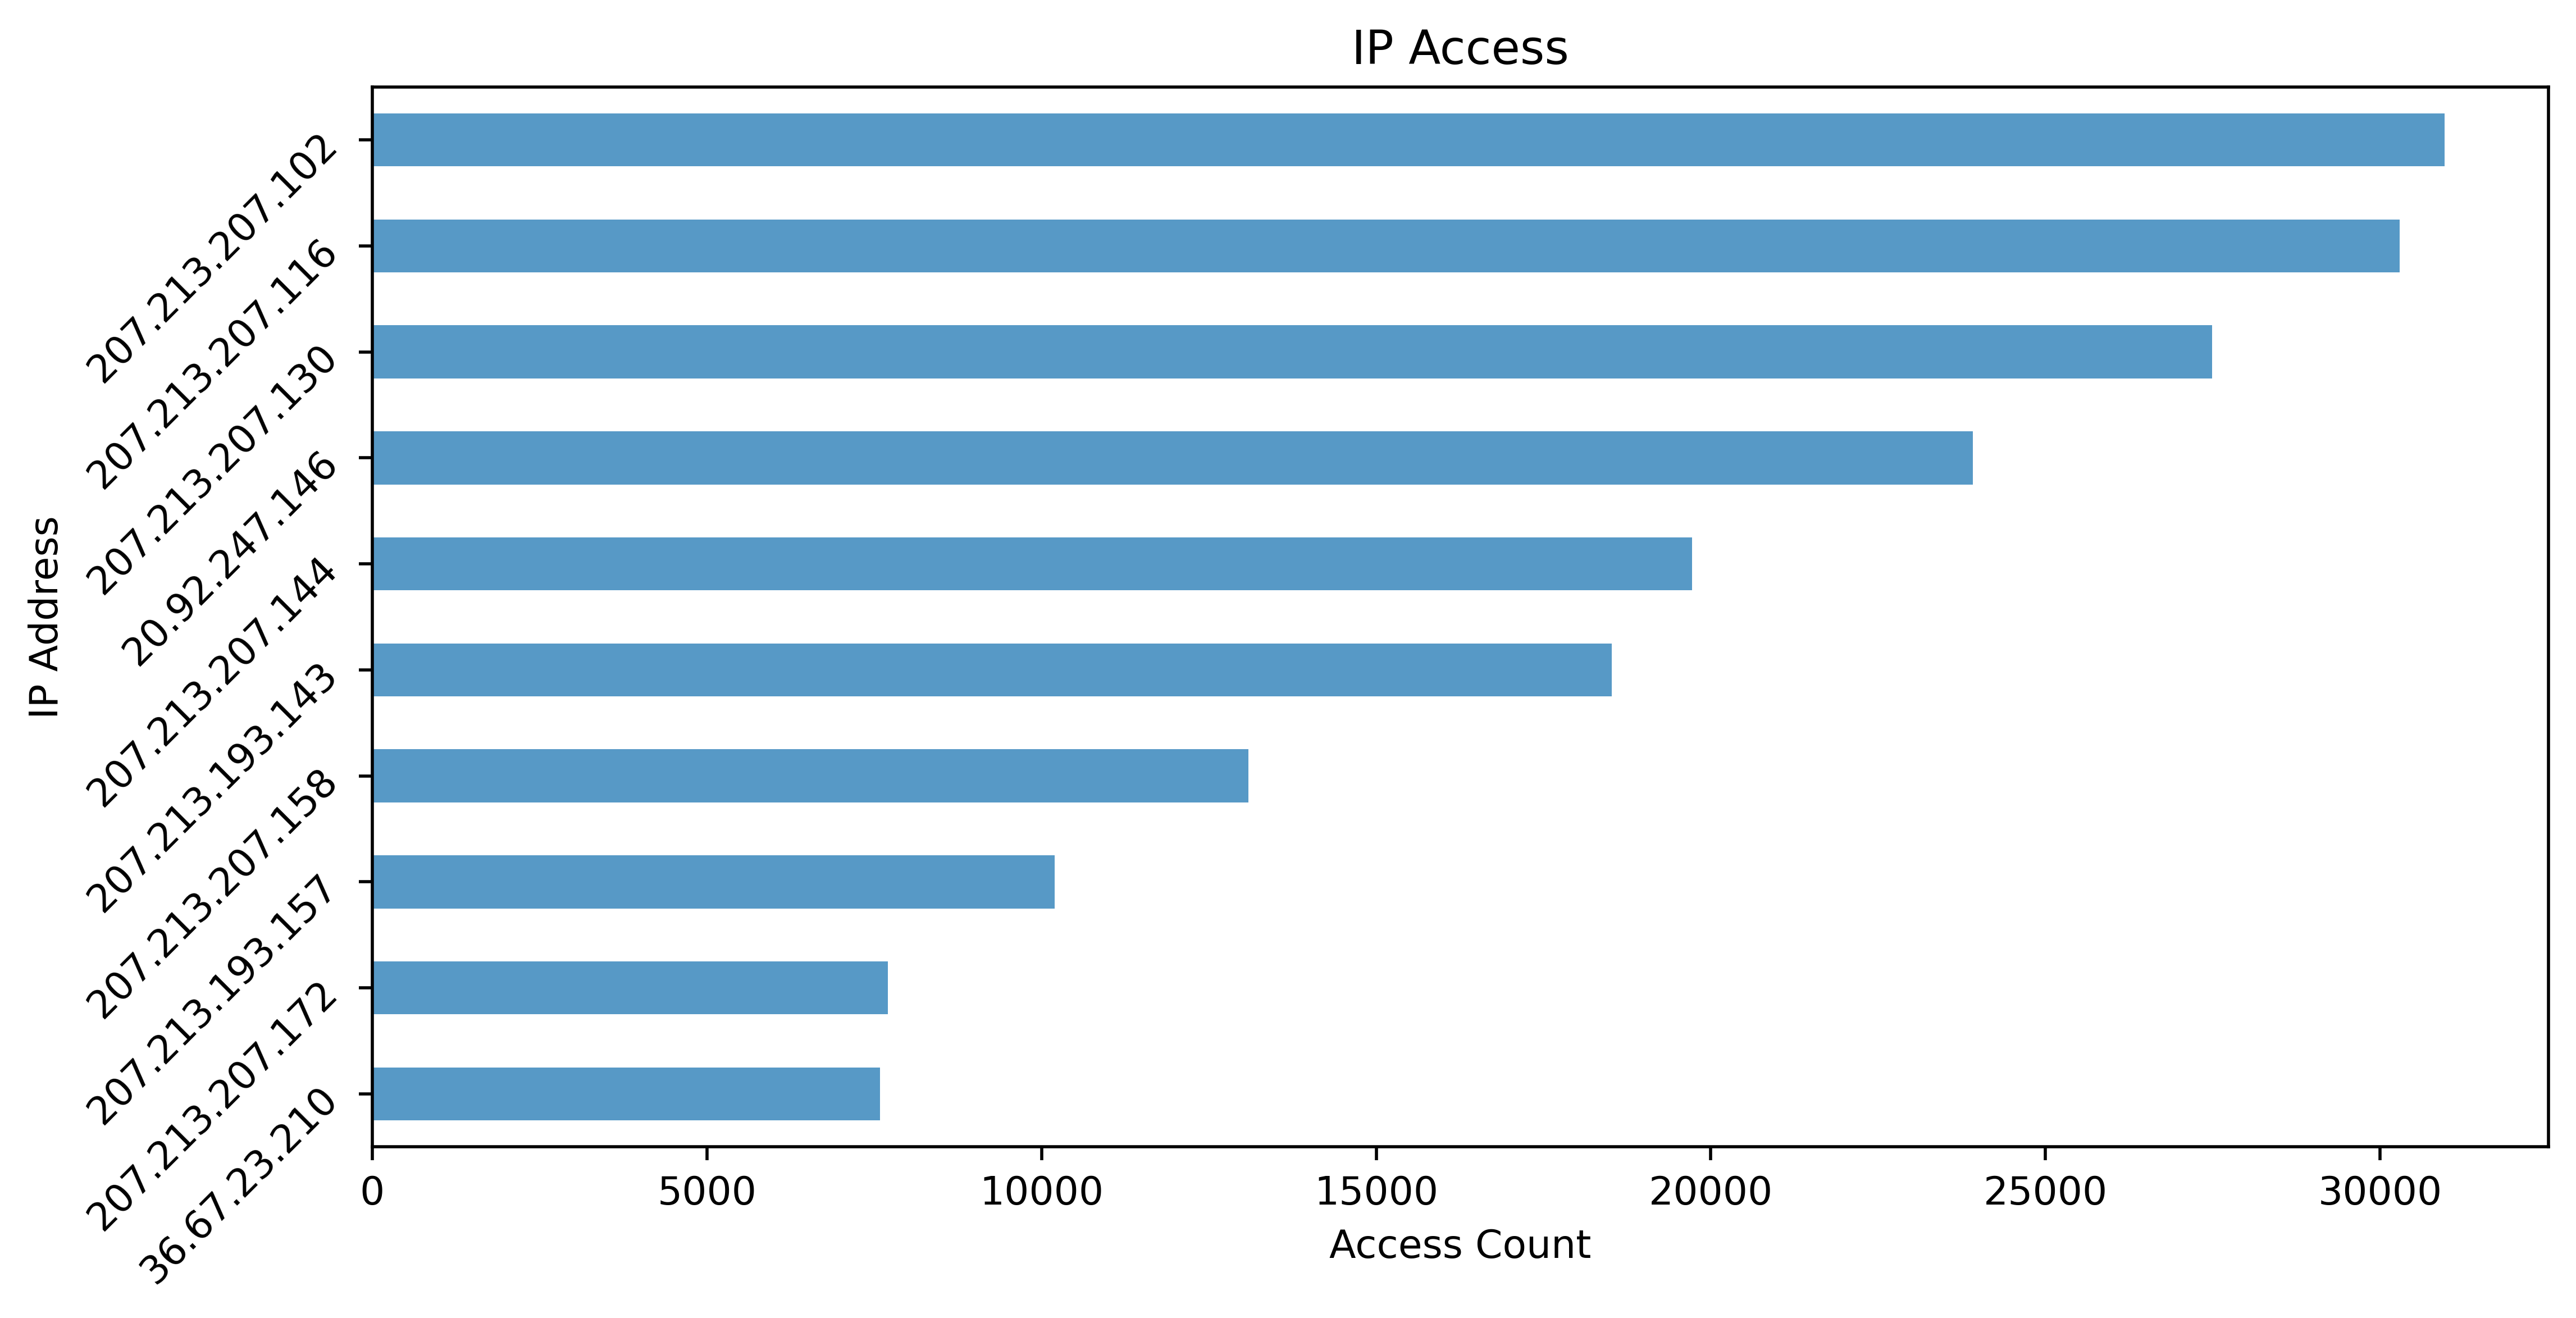

In [15]:
def top_ip(df, n=10):
    ip = df.groupby('ip')['ip'].agg(len)
    sorted_ip = ip.sort_values()[-n:]
    fig = plt.figure(figsize=(10,5), dpi=500)
    ax = sorted_ip.plot(kind='barh', title='IP Access', rot=45, alpha=0.75)
    ax.set_xlabel('Access Count')
    ax.set_ylabel('IP Address')
    

top_ip(df, n=10)

### 1.1.2 The most requested endpoints

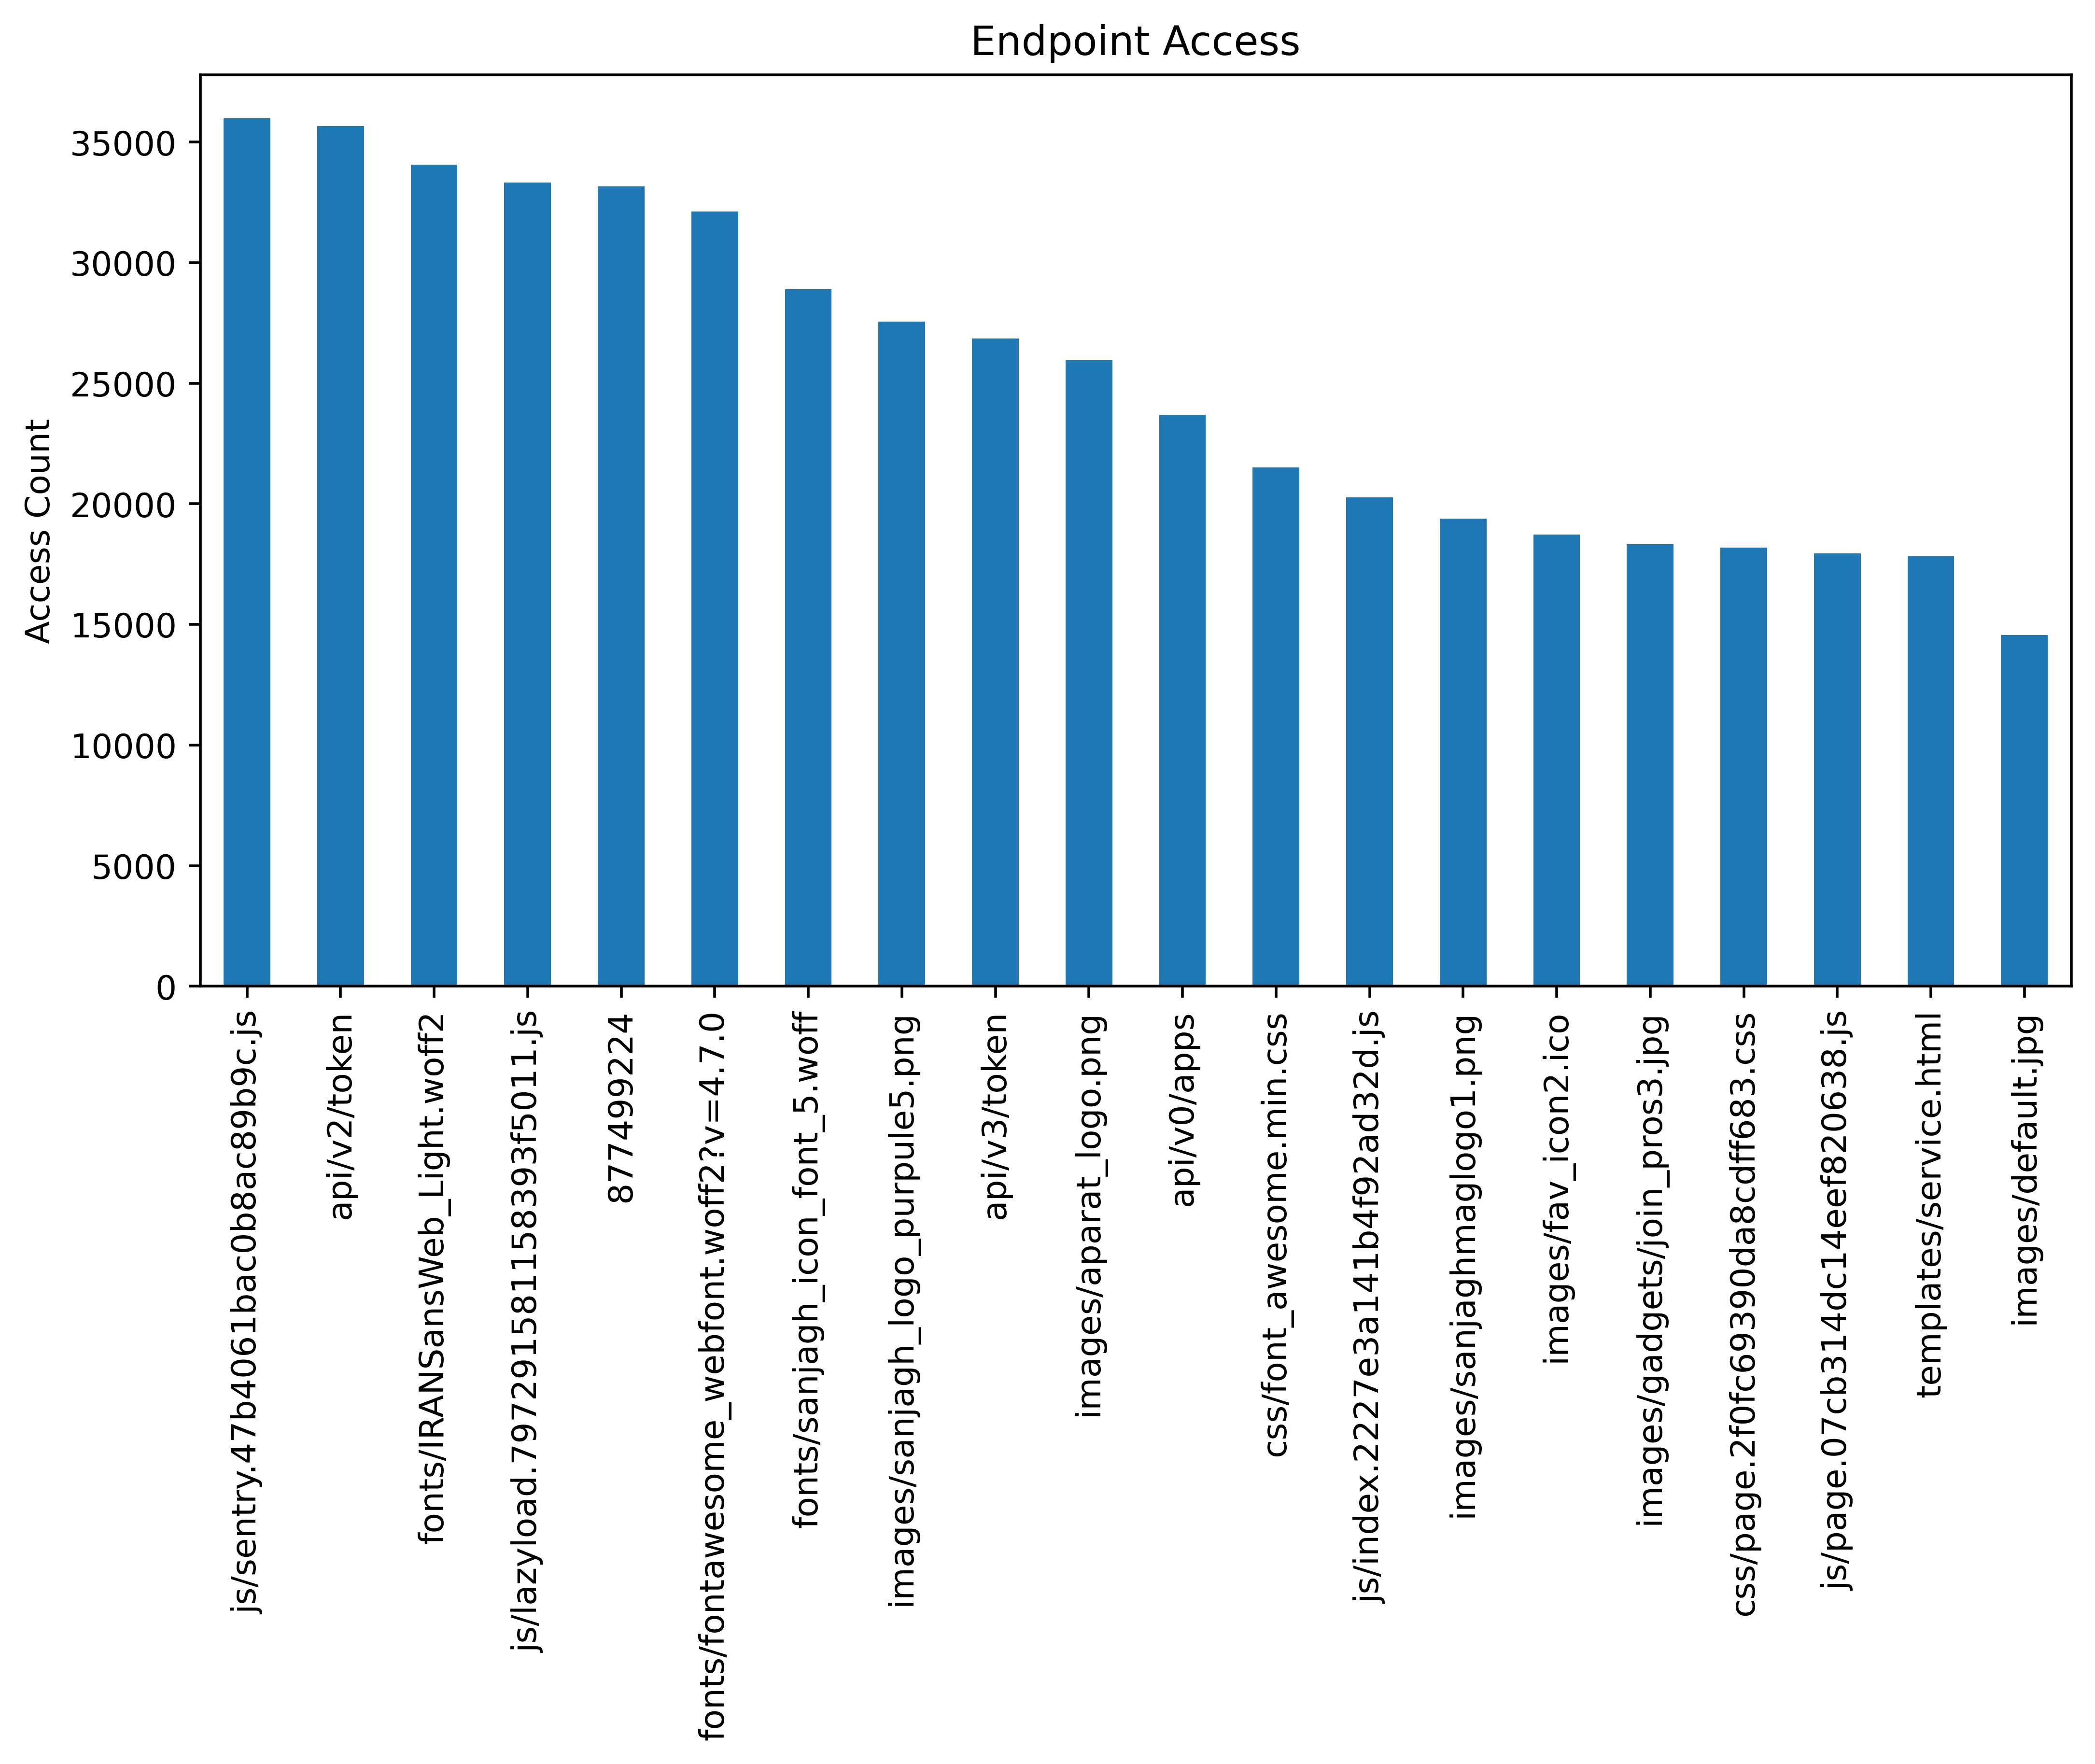

In [16]:
def top_request_endpoint(df, n=10):
    path = df['path']
    fig = plt.figure(figsize=(10,5), dpi=500)
    ax = path.value_counts()[:n].plot(kind='bar', title='Endpoint Access')
    ax.set_ylabel('Access Count')
    
top_request_endpoint(df, n=20)

Now let's add a column into the main dataframe which indicates the normalized count of the path for each request.

In [17]:
# note that "len" counts the NaN value as well.
df['path_count_normalized'] = df.groupby(['path'])['path'].transform(len)
df['path_count_normalized'] = (df['path_count_normalized'] / len(df)) * 100

df.sort_values('path_count_normalized', ascending=True)

,ip,time,method,status_code,path,response_length,user_agent,response_time,path_count_normalized
414594,35.181.48.183,2021-05-12 10:26:35+04:30,Get,101,api/v2/connect/399347174,163178,okhttp/3.12.1,466660.0,0.000081
281853,92.239.251.116,2021-05-12 09:22:38+04:30,Get,101,api/v2/connect/561682383,21116,Mozilla/5.0 (Linux; Android 8.1.0; SM-J701F Bu...,79323.0,0.000081
105594,35.47.111.170,2021-05-12 06:39:26+04:30,Get,101,api/v2/connect/2093511165,37419,okhttp/3.12.1,107222.0,0.000081
281854,123.252.16.112,2021-05-12 09:22:38+04:30,Get,200,order/1928683331/208096507,72964,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,132.0,0.000081
631341,217.14.194.108,2021-05-12 11:58:03+04:30,Get,101,api/v2/connect/1059797473,0,okhttp/3.12.1,60003.0,0.000081
...,...,...,...,...,...,...,...,...,...
15425,36.67.29.105,2021-05-12 05:17:44+04:30,Get,200,js/sentry.47b4061bac0b8ac89b9c.js,65059,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,4.0,2.898040
87630,35.244.226.239,2021-05-12 06:14:36+04:30,Get,200,js/sentry.47b4061bac0b8ac89b9c.js,65059,Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-...,4.0,2.898040
157128,244.3.78.214,2021-05-12 07:55:40+04:30,Get,200,js/sentry.47b4061bac0b8ac89b9c.js,65059,Mozilla/5.0 (Windows NT 6.1; rv:88.0) Gecko/20...,4.0,2.898040
410975,35.96.173.211,2021-05-12 10:25:09+04:30,Get,200,js/sentry.47b4061bac0b8ac89b9c.js,65059,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,12.0,2.898040


### 1.1.3 HTTP method with the most requests

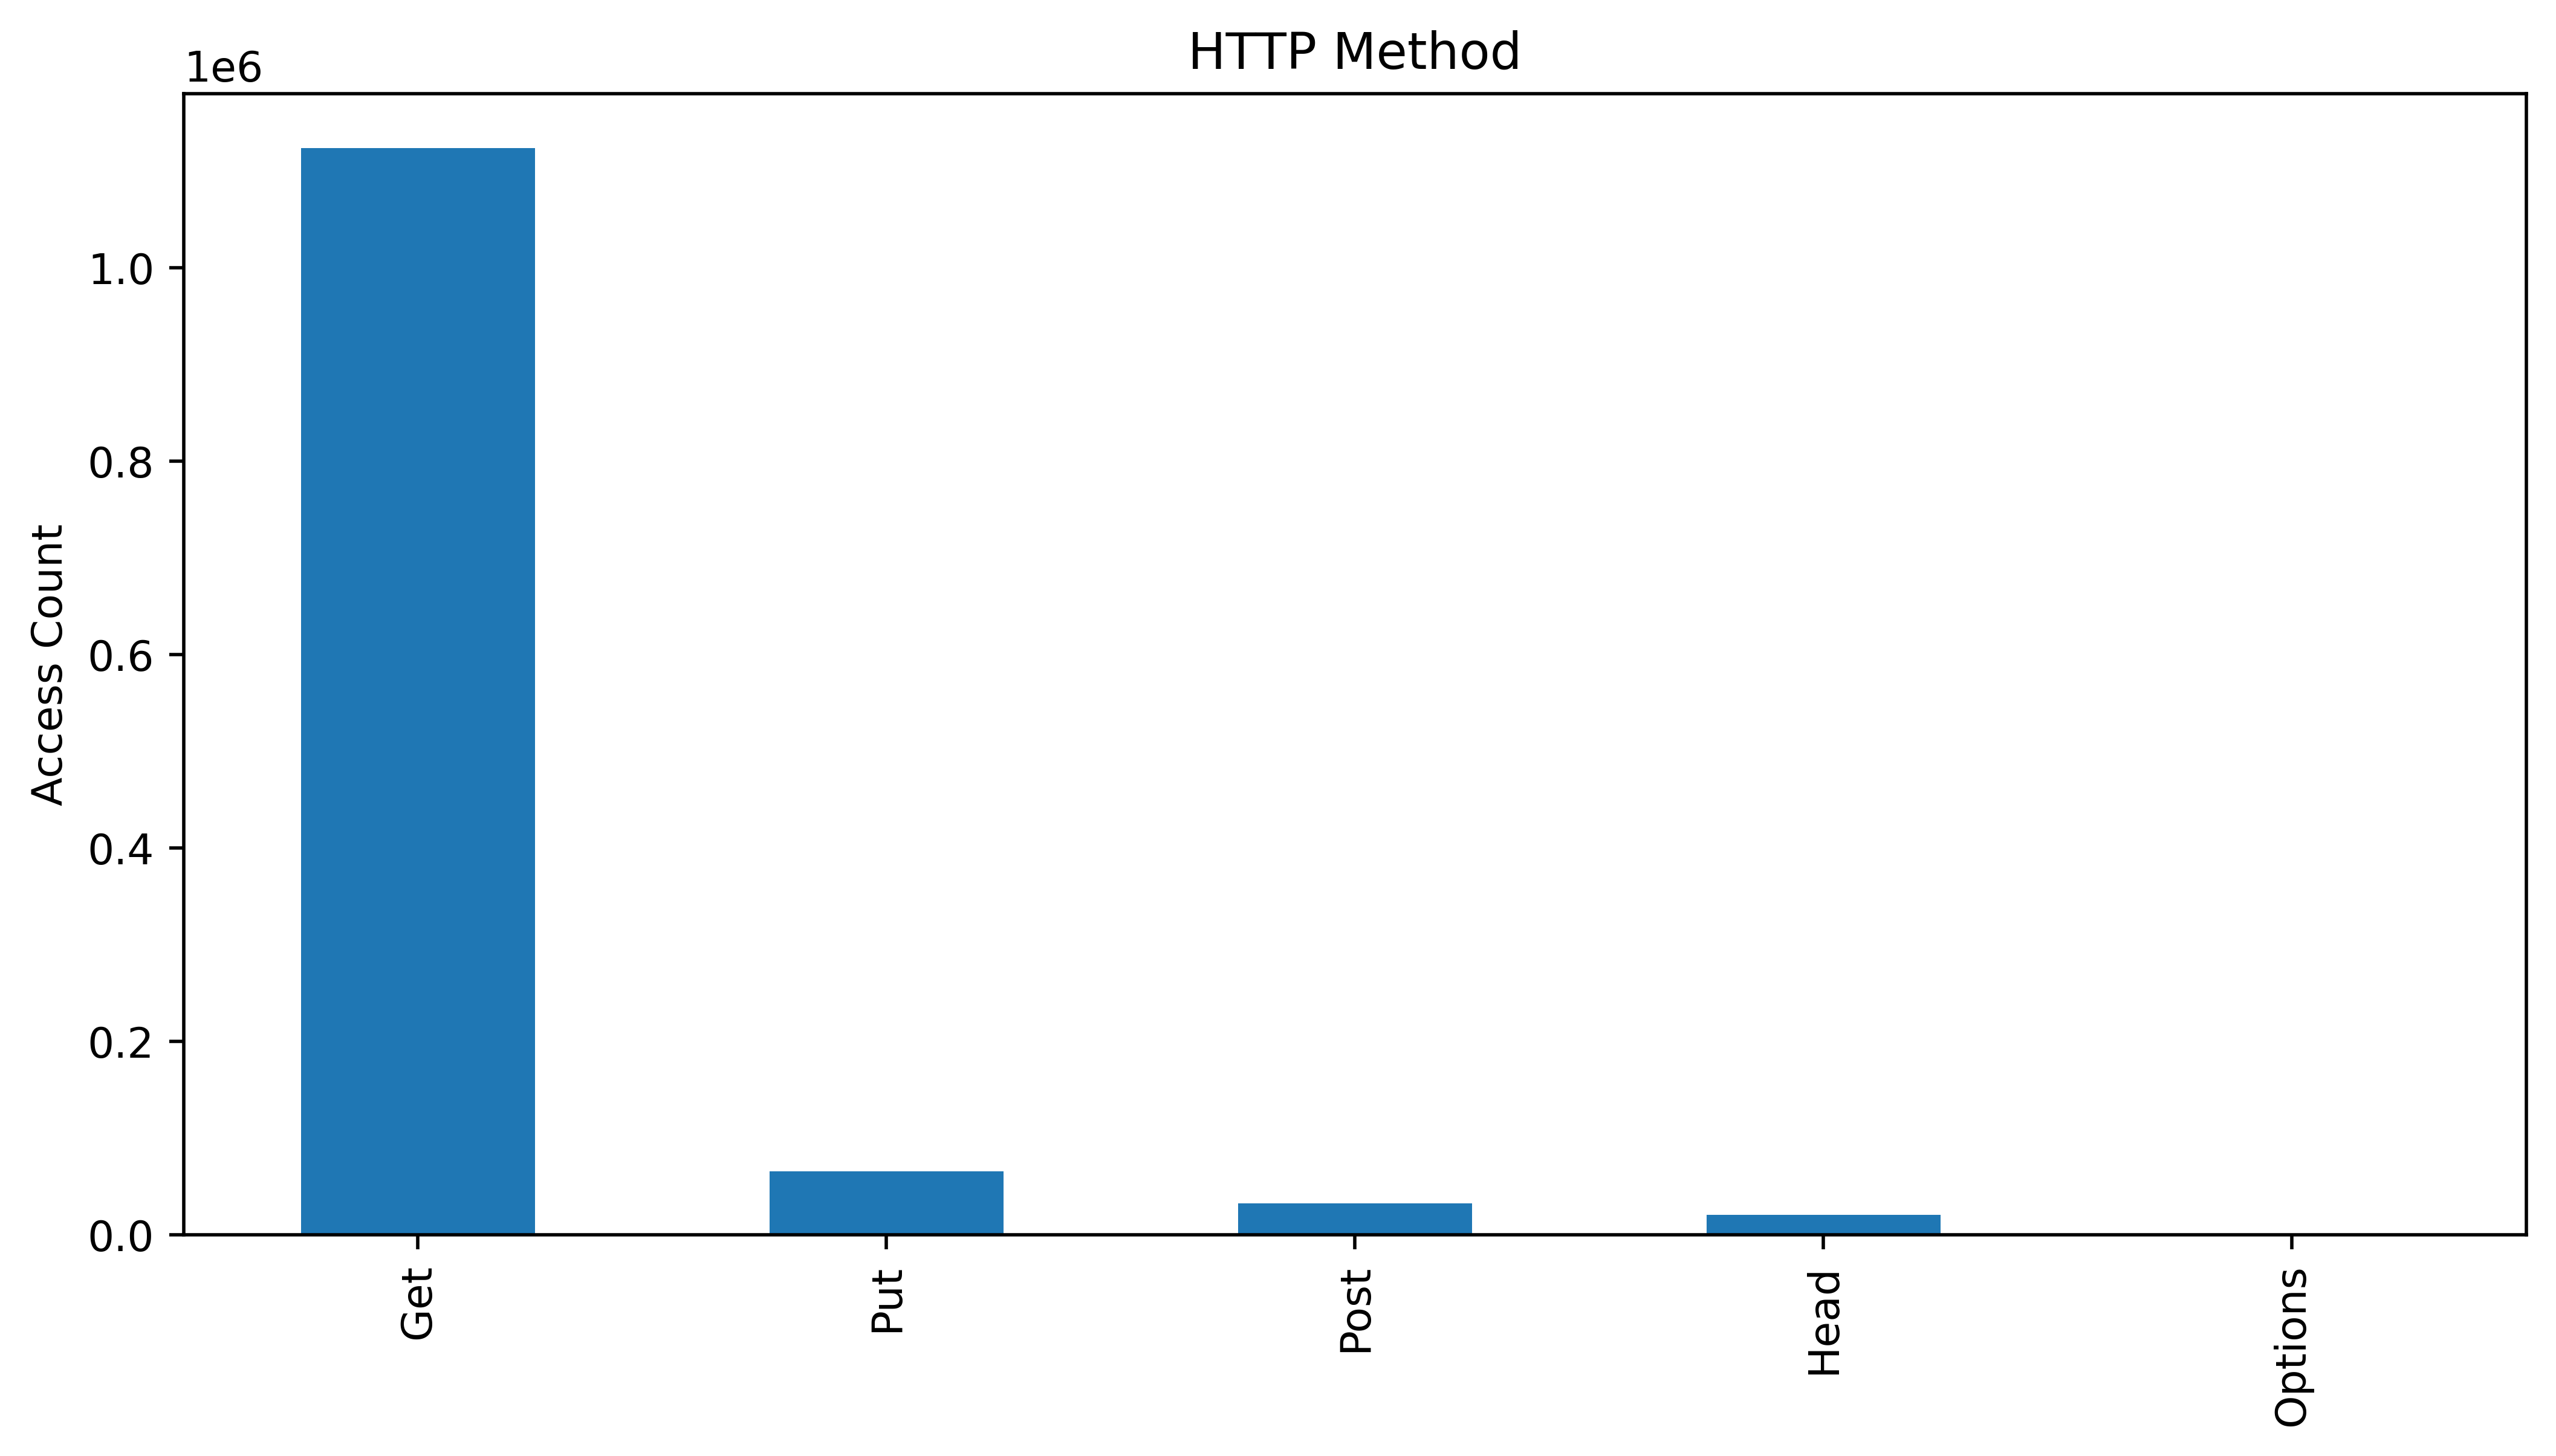

In [18]:
def top_request_method(df):
    method = df['method']
    fig = plt.figure(figsize=(10,5), dpi=500)
    ax = method.value_counts().plot(kind='bar', title='HTTP Method')
    ax.set_ylabel('Access Count')
    plt.show()
    
top_request_method(df)

### 1.1.4 The most common user agents

First of all, lets add some useful features which can be adapted from the raw user agent. We used [user agents library](https://pypi.org/project/user-agents/) for this purpose.

In [21]:
# set the user agent browser family for each request
df['browser'] = df['user_agent'].apply(lambda x : parse(x).browser.family)
# set the user agent os family for each request
df['os'] = df['user_agent'].apply(lambda x : parse(x).os.family)
# check if the request is from a bot or not!
df['is_bot'] = df['user_agent'].apply(lambda x : parse(x).is_bot)
# check if the request is from a pc or not!
df['is_pc'] = df['user_agent'].apply(lambda x : parse(x).is_pc)

df

,ip,time,method,status_code,path,response_length,user_agent,response_time,path_count_normalized,browser,os,is_bot,is_pc
0,207.213.193.143,2021-05-12 05:06:00+04:30,Get,304,cdn/profiles/1026106239,0,Googlebot-Image/1.0,32.0,0.011434,Googlebot-Image,Other,True,False
1,207.213.193.143,2021-05-12 05:06:00+04:30,Get,304,images/badge.png,0,Googlebot-Image/1.0,4.0,1.009145,Googlebot-Image,Other,True,False
2,35.110.222.153,2021-05-12 05:06:00+04:30,Get,200,pages/630180847,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32.0,0.101132,Samsung Internet,Android,False,False
3,35.108.208.99,2021-05-12 05:06:00+04:30,Get,200,images/fav_icon2.ico,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20.0,1.508523,Chrome Mobile,Android,False,False
4,35.110.222.153,2021-05-12 05:06:00+04:30,Get,200,images/sanjagh_logo_purpule5.png,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8.0,2.218701,Samsung Internet,Android,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260028,35.117.86.75,2021-05-12 15:08:59+04:30,Get,304,images/graystar_min.png,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4.0,1.068165,Chrome Mobile,Android,False,False
1260029,35.117.86.75,2021-05-12 15:08:59+04:30,Get,304,fonts/sanjagh_icon_font_5.woff,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4.0,2.326355,Chrome Mobile,Android,False,False
1260030,153.126.251.199,2021-05-12 15:08:59+04:30,Get,101,api/v2/connect/215865643,0,okhttp/3.12.1,60003.0,0.000081,okhttp,Other,False,False
1260031,207.213.207.102,2021-05-12 15:08:59+04:30,Get,304,cdn/profiles/1289255230,0,Googlebot-Image/1.0,20.0,0.000564,Googlebot-Image,Other,True,False


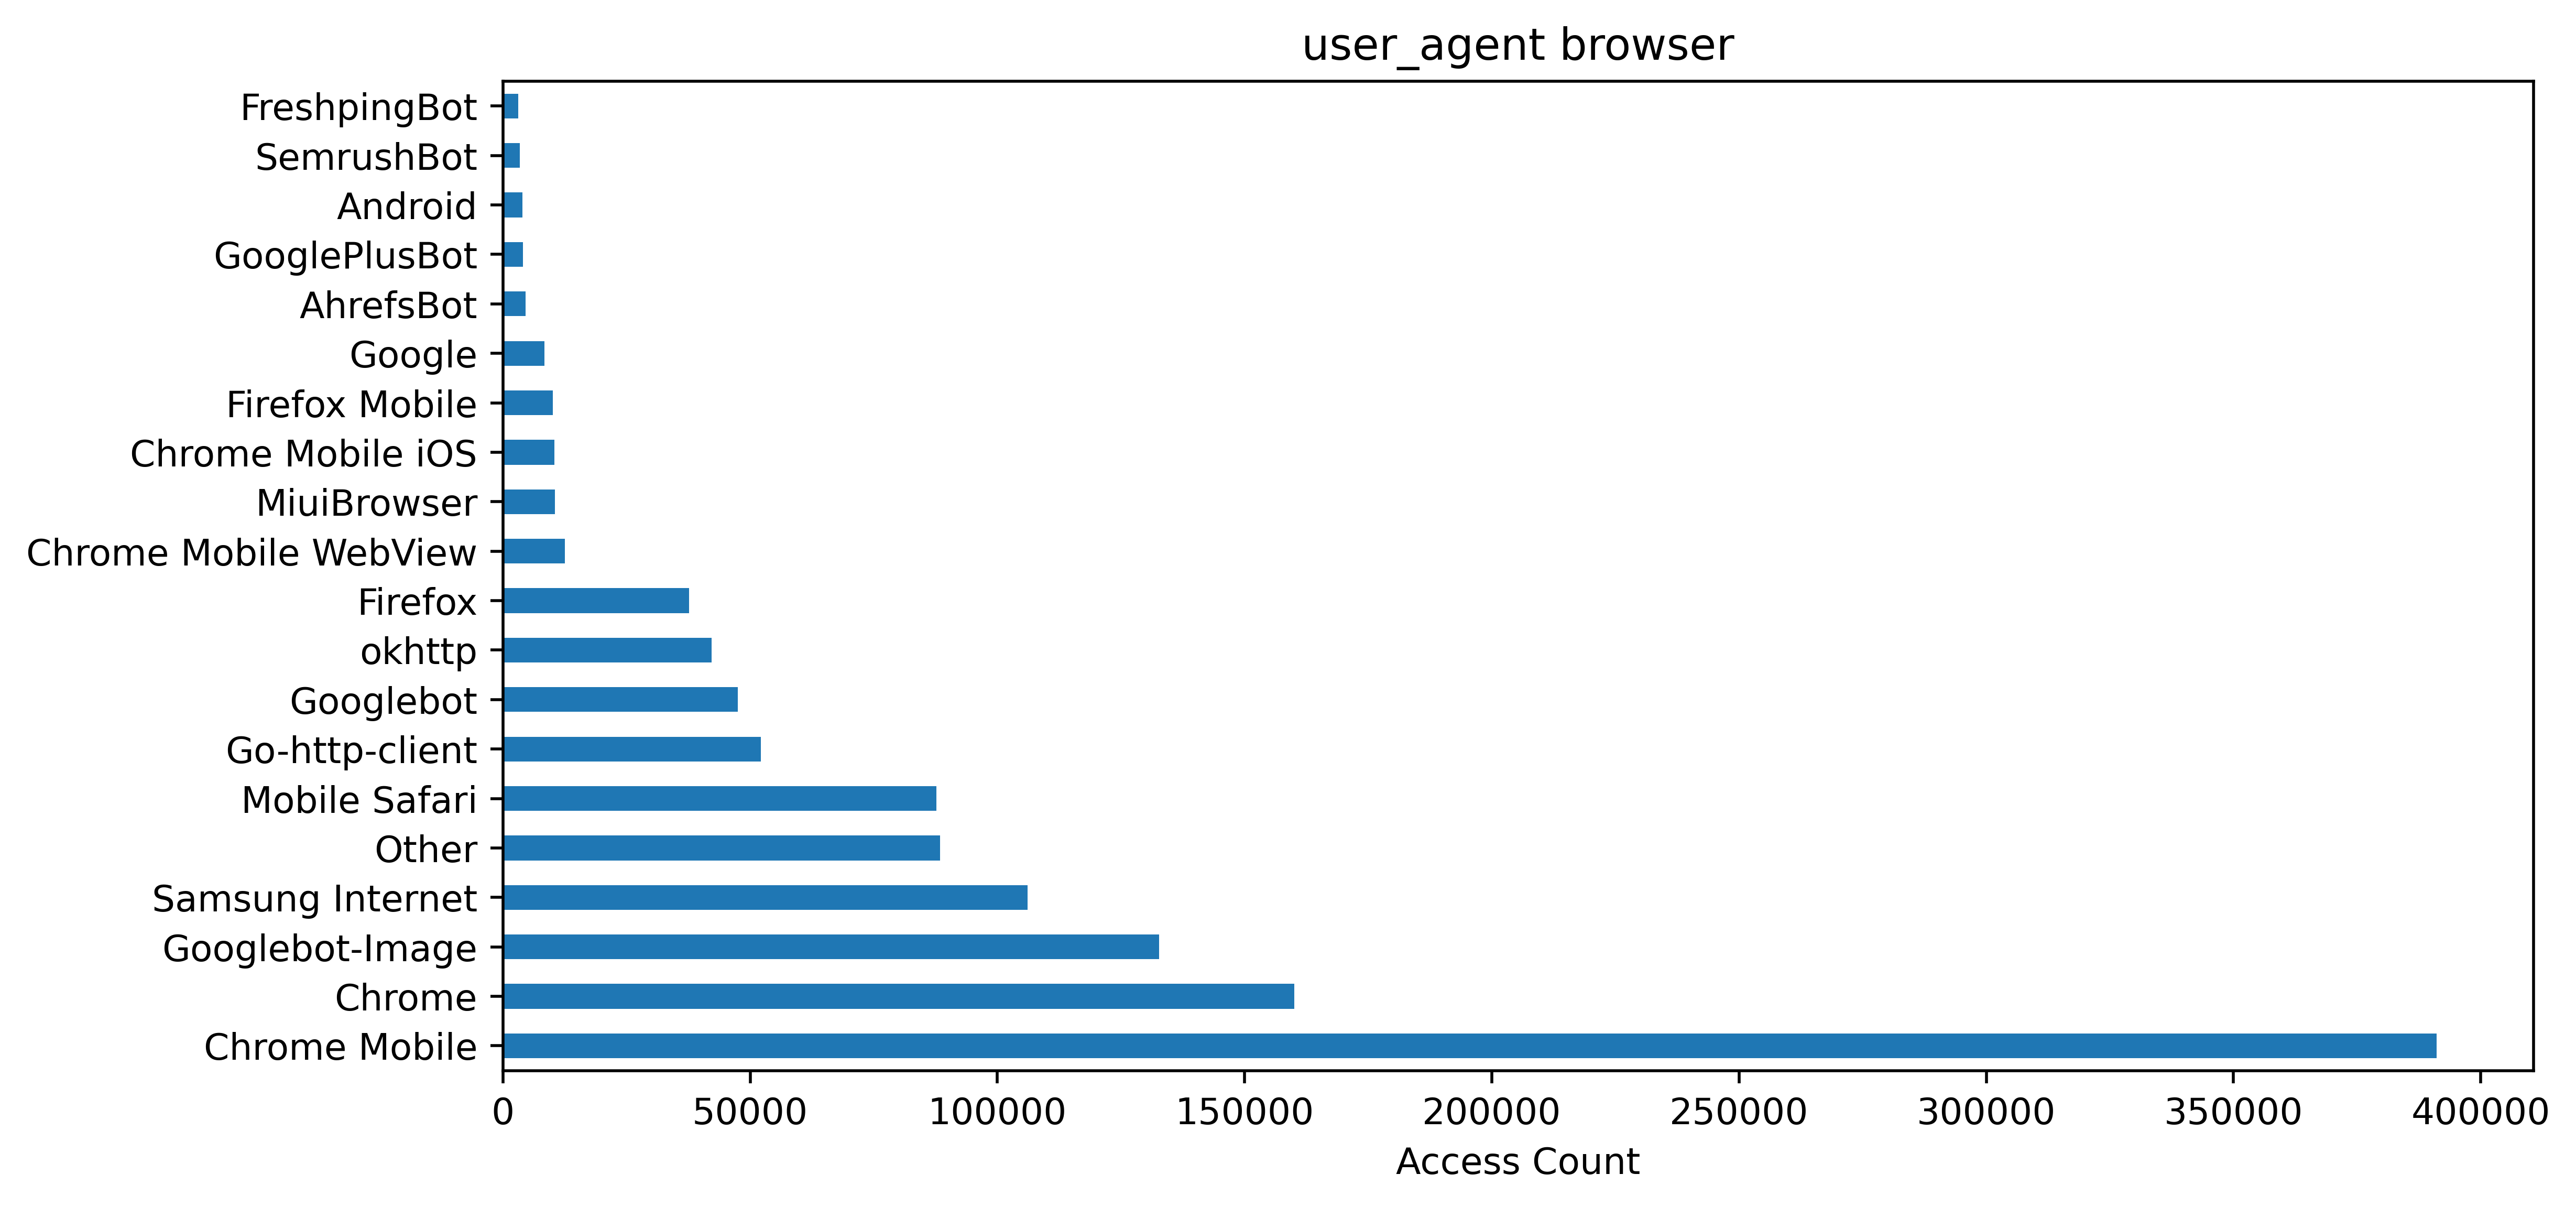

In [22]:
def top_user_agent(df, n=10):
    user_agent_browser = df['browser']
    fig = plt.figure(figsize=(10,5), dpi=500)
    ax = user_agent_browser.value_counts()[:n].plot(kind='barh', title='user_agent browser')
    ax.set_xlabel('Access Count')
    plt.show()
    
top_user_agent(df, n=20)

In [23]:
# note that "len" counts the NaN value as well.
df['browser_norm'] = df.groupby(['browser'])['browser'].transform(len)
df['browser_norm'] = (df['browser_norm'] / len(df)) * 100

df['os_norm'] = df.groupby(['os'])['os'].transform(len)
df['os_norm'] = (df['os_norm'] / len(df)) * 100

df

,ip,time,method,status_code,path,response_length,user_agent,response_time,path_count_normalized,browser,os,is_bot,is_pc,browser_norm,os_norm
0,207.213.193.143,2021-05-12 05:06:00+04:30,Get,304,cdn/profiles/1026106239,0,Googlebot-Image/1.0,32.0,0.011434,Googlebot-Image,Other,True,False,10.685998,21.742141
1,207.213.193.143,2021-05-12 05:06:00+04:30,Get,304,images/badge.png,0,Googlebot-Image/1.0,4.0,1.009145,Googlebot-Image,Other,True,False,10.685998,21.742141
2,35.110.222.153,2021-05-12 05:06:00+04:30,Get,200,pages/630180847,52567,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,32.0,0.101132,Samsung Internet,Android,False,False,8.546527,48.634680
3,35.108.208.99,2021-05-12 05:06:00+04:30,Get,200,images/fav_icon2.ico,23531,Mozilla/5.0 (Linux; Android 6.0; CAM-L21) Appl...,20.0,1.508523,Chrome Mobile,Android,False,False,31.491783,48.634680
4,35.110.222.153,2021-05-12 05:06:00+04:30,Get,200,images/sanjagh_logo_purpule5.png,4680,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,8.0,2.218701,Samsung Internet,Android,False,False,8.546527,48.634680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260028,35.117.86.75,2021-05-12 15:08:59+04:30,Get,304,images/graystar_min.png,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4.0,1.068165,Chrome Mobile,Android,False,False,31.491783,48.634680
1260029,35.117.86.75,2021-05-12 15:08:59+04:30,Get,304,fonts/sanjagh_icon_font_5.woff,0,Mozilla/5.0 (Linux; Android 9; Redmi 7A) Apple...,4.0,2.326355,Chrome Mobile,Android,False,False,31.491783,48.634680
1260030,153.126.251.199,2021-05-12 15:08:59+04:30,Get,101,api/v2/connect/215865643,0,okhttp/3.12.1,60003.0,0.000081,okhttp,Other,False,False,3.395647,21.742141
1260031,207.213.207.102,2021-05-12 15:08:59+04:30,Get,304,cdn/profiles/1289255230,0,Googlebot-Image/1.0,20.0,0.000564,Googlebot-Image,Other,True,False,10.685998,21.742141


In [24]:
df.columns

Index(['ip', 'time', 'method', 'status_code', 'path', 'response_length',
       'user_agent', 'response_time', 'path_count_normalized', 'browser', 'os',
       'is_bot', 'is_pc', 'browser_norm', 'os_norm'],
      dtype='object')

## 1.3 Features per user

### 1.3.1 number of requests per user
Higher rates signals the presence of web crawlers.

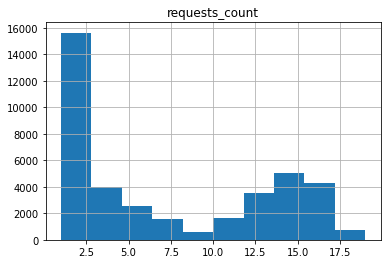

In [25]:
def requests_per_user(df):
    request_counts_df = pd.DataFrame(df.groupby(['ip', 'user_agent']).size(),
                        columns=['requests_count'])
    
    # plot the histogram for uesr with less than 20 requests
    request_counts_df[request_counts_df['requests_count'] < 20].hist(bins=10)
    
requests_per_user(df)
    

In [26]:
user_df = pd.DataFrame(df.groupby(['ip', 'user_agent']).size(),
                        columns=['requests_count'])

user_df.sort_values('requests_count', ascending=False)

requests_count
ip              user_agent                                                        
20.92.247.146   sentry/21.4.1 (https://sentry.io)                            23912
207.213.207.102 Googlebot-Image/1.0                                          23627
207.213.207.116 Googlebot-Image/1.0                                          23380
207.213.207.130 Googlebot-Image/1.0                                          21494
207.213.207.144 Googlebot-Image/1.0                                          15363
...                                                                            ...
35.202.69.199   Mozilla/5.0 (compatible; heritrix/3.4.0-2020030...               1
35.202.76.221   MoziIIa/5.0 (X11; Linux x86_64) app_version: 581                 1
                okhttp/3.12.1                                                    1
35.202.77.168   MoziIIa/5.0 (X11; Linux x86_64) app_version: 581                 1
99.96.90.10     Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like Ma...               1

[51123 rows x 1 columns]

### 1.3.2 Std of path length per user
Deeper requests usually indicates a human user.


In [28]:
# set the path length for each request
df['path_length'] = df['path'].apply(lambda x : len(x.split('/')))
# create a dataframe that includes std of the path_lengths per user
user_df['path_length_std'] = df.groupby(['ip', 'user_agent'])['path_length'].agg('std')

user_df['path_length_std'] = user_df['path_length_std'].fillna(0)
user_df[user_df['requests_count'] > 5].sort_values(['path_length_std', 'requests_count'], ascending=True)

,,requests_count,path_length_std
ip,user_agent,,
102.24.134.34,MoziIIa/5.0 (X11; Linux x86_64) app_version: 735,6,0.000000
102.86.13.63,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.000000
11.127.239.60,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:24.0) Gecko/20100101 Firefox/24.0,6,0.000000
11.15.187.44,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.000000
113.111.148.141,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.000000
...,...,...,...
35.40.250.12,"Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-G610F Build/M1AJQ) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/7.2 Chrome/59.0.3071.125 Mobile Safari/537.36",6,1.366260
35.47.11.128,"Mozilla/5.0 (Linux; Android 10; SAMSUNG SM-A315F) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/11.0 Chrome/75.0.3770.143 Mobile Safari/537.36",6,1.366260
35.47.61.163,"Mozilla/5.0 (Linux; Android 9; SAMSUNG SM-A105F) AppleWebKit/537.36 (KHTML, like Gecko) SamsungBrowser/14.0 Chrome/87.0.4280.141 Mobile Safari/537.36",6,1.366260


### 1.3.3 Percentage of 4xx response codes per user
Usually higher for crawlers as there is higher chances of hitting an outdated or deleted page.

In [29]:
# fetch the requests with 4xx responses
resp_400 = df[df['status_code'] > 400]
# create a column in user_df dataframe as "4xx_counts" which includes the number of 4xx
# responses per user.
user_df['4xx_counts'] = resp_400.groupby(['ip', 'user_agent'])['status_code'].agg('size')
user_df['4xx_counts'] = user_df['4xx_counts'].fillna(0)

user_df['4xx_percentage(%)'] = (user_df['4xx_counts'] / user_df['requests_count']) * 100
# drop 4xx_counts column
user_df.drop(columns=['4xx_counts'], inplace=True)

user_df[user_df['requests_count'] > 5].sort_values(['4xx_percentage(%)', 'requests_count'], ascending=False)

,,requests_count,path_length_std,4xx_percentage(%)
ip,user_agent,,,
35.124.193.182,Dalvik/2.1.0 (Linux; U; Android 10; SM-A115F Build/QP1A.190711.020),104,0.00000,100.0
153.126.209.239,Go-http-client/1.1,35,0.00000,100.0
35.244.120.44,Go-http-client/1.1,18,0.00000,100.0
35.232.97.81,okhttp/2.5.0,9,0.00000,100.0
35.132.136.207,MobileSafari/604.1 CFNetwork/1240.0.4 Darwin/20.5.0,8,0.00000,100.0
...,...,...,...,...
92.144.239.236,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.83666,0.0
92.144.77.249,MoziIIa/5.0 (X11; Linux x86_64) app_version: 735,6,0.00000,0.0
92.239.17.78,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.83666,0.0


### 1.3.3.1 Percentage of 3xx response codes per user

In [30]:
# fetch the requests with 3xx responses
resp_300 = df[(df['status_code'] >= 300) & (df['status_code'] < 400)]
# create a column in user_df dataframe as "3xx_counts" which includes the number of 3xx
# responses per user.
user_df['3xx_counts'] = resp_300.groupby(['ip', 'user_agent'])['status_code'].agg('size')
user_df['3xx_counts'] = user_df['3xx_counts'].fillna(0)

user_df['3xx_percentage(%)'] = (user_df['3xx_counts'] / user_df['requests_count']) * 100
# drop 3xx_counts column
user_df.drop(columns=['3xx_counts'], inplace=True)

user_df[user_df['requests_count'] > 5].sort_values(['3xx_percentage(%)', 'requests_count'], ascending=False)

,,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%)
ip,user_agent,,,,
207.213.193.213,Googlebot-Image/1.0,71,0.257679,0.0,100.0
217.98.85.154,"Mozilla/5.0 (Linux; Android 10; SM-A105F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.88 Mobile Safari/537.36",54,0.292582,0.0,100.0
14.240.9.74,"Mozilla/5.0 (Linux; Android 8.1.0; DUB-LX1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.181 Mobile Safari/537.36",50,0.274048,0.0,100.0
35.108.36.67,"Mozilla/5.0 (Linux; Android 8.1.0; SM-G610F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.51 Mobile Safari/537.36",39,0.269953,0.0,100.0
4.115.196.73,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.77 Safari/537.36",39,0.269953,0.0,100.0
...,...,...,...,...,...
92.144.239.236,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.836660,0.0,0.0
92.144.77.249,MoziIIa/5.0 (X11; Linux x86_64) app_version: 735,6,0.000000,0.0,0.0
92.239.17.78,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.836660,0.0,0.0


### 1.3.4 Percentage of HTTP HEAD requests, per user
Indicates a web crawler.

In [31]:
# fetch the requests with HEAD method
HTTP_HEAD = df[df['method'] == 'Head']
# create a column in user_df dataframe as "HEAD_count" which includes the number of HEAD
# requests per user.
user_df['HEAD_count'] = HTTP_HEAD.groupby(['ip', 'user_agent'])['method'].agg('size')
user_df['HEAD_count'] = user_df['HEAD_count'].fillna(0)

user_df['HEAD_count(%)'] = (user_df['HEAD_count'] / user_df['requests_count']) * 100
# drop HEAD_count column
user_df.drop(columns=['HEAD_count'], inplace=True)

user_df[user_df['requests_count'] > 5].sort_values(['HEAD_count(%)', 'requests_count'], ascending=False)

,,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%)
ip,user_agent,,,,,
20.163.161.41,"Mozilla/5.0 (iPhone; CPU iPhone OS 7_0 like Mac OS X; en-us) AppleWebKit/537.51.1 (KHTML, like Gecko) Version/7.0 Mobile/11A465 Safari/9537.53",37,0.538321,0.000000,0.000000,72.972973
36.67.23.210,Go-http-client/2.0,7582,0.475879,1.609074,9.773147,45.805856
60.148.0.167,Go-http-client/2.0,7351,0.479779,1.714053,10.053054,43.980411
20.92.247.170,Go-http-client/2.0,7273,0.482874,0.000000,10.325863,42.334662
76.212.164.3,Go-http-client/2.0,6549,0.487955,1.878149,9.406016,42.113300
...,...,...,...,...,...,...
92.144.239.236,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.836660,0.000000,0.000000,0.000000
92.144.77.249,MoziIIa/5.0 (X11; Linux x86_64) app_version: 735,6,0.000000,0.000000,0.000000,0.000000
92.239.17.78,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,6,0.836660,0.000000,0.000000,0.000000


### 1.3.5 Percentage of image requests per user

Web crawlers usually ignore images.

In [32]:
# fetch the image requests
condition_1 = df['path'].str.contains('images',case=False)
condition_2 = df['path'].str.endswith('.png') | df['path'].str.endswith('.jpg')
image_requests = df[condition_1 | condition_2]
# create a column in user_df dataframe as "image_count" which contains the number of image
# requests per user.
user_df['image_count'] = image_requests.groupby(['ip', 'user_agent'])['path'].agg('size')
user_df['image_count'] = user_df['image_count'].fillna(0)

user_df['image_count(%)'] = (user_df['image_count'] / user_df['requests_count']) * 100
# drop image_count column
user_df.drop(columns=['image_count'], inplace=True)

user_df[user_df['requests_count'] > 20].sort_values(['image_count(%)', 'requests_count'], ascending=True).head(10)

,,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%)
ip,user_agent,,,,,,
102.29.29.19,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.000000,0.0,0.0,0.0,0.0
113.11.38.30,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.749603,0.0,0.0,0.0,0.0
113.111.195.219,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.000000,0.0,0.0,0.0,0.0
113.118.175.102,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.810643,0.0,0.0,0.0,0.0
113.118.45.106,okhttp/3.12.1,21,0.436436,0.0,0.0,0.0,0.0
113.118.90.28,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.810643,0.0,0.0,0.0,0.0
113.118.96.94,okhttp/3.12.1,21,0.358569,0.0,0.0,0.0,0.0
113.74.79.241,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.810643,0.0,0.0,0.0,0.0
113.97.91.168,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,21,0.643650,0.0,0.0,0.0,0.0


### 1.3.6 Average and sum of the response length and response time per user

Human users retrieve information from the Web via some interface, such as web browser. This interface forces the user's session to request additional resources automatically.

In [33]:
user_df['total_response_length'] = df.groupby(['ip', 'user_agent'])['response_length'].agg('sum')
user_df['mean_response_length'] = df.groupby(['ip', 'user_agent'])['response_length'].agg('mean')

user_df['total_response_time'] = df.groupby(['ip', 'user_agent'])['response_time'].agg('sum')
user_df['mean_response_time'] = df.groupby(['ip', 'user_agent'])['response_time'].agg('mean')

user_df[(user_df['requests_count'] > 5) & 
        (user_df['3xx_percentage(%)'] < 20)].sort_values(
    by=['mean_response_time', 'mean_response_length'], ascending=True)

,,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time
ip,user_agent,,,,,,,,,,
29.240.244.96,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1) AppleWebKit/601.2.4 (KHTML, like Gecko) Version/9.0.1 Safari/601.2.4 facebookexternalhit/1.1 Facebot Twitterbot/1.0",8,0.462910,75.000000,0.00,0.0,25.000000,226024,28253.000000,24.0,3.000000e+00
93.113.11.166,"Mozilla/5.0 (iPhone; CPU iPhone OS 14_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1",7,0.377964,0.000000,0.00,0.0,100.000000,123854,17693.428571,24.0,3.428571e+00
155.114.254.242,"Mozilla/5.0 (iPhone; CPU iPhone OS 13_5_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Mobile/15E148 Safari/604.1",16,0.250000,0.000000,6.25,0.0,43.750000,777988,48624.250000,60.0,3.750000e+00
14.240.166.247,Mozilla/5.0 (Android 5.0.2; Mobile; rv:87.0) Gecko/87.0 Firefox/87.0,6,0.000000,66.666667,0.00,0.0,50.000000,76940,12823.333333,24.0,4.000000e+00
35.132.136.207,MobileSafari/604.1 CFNetwork/1240.0.4 Darwin/20.5.0,8,0.000000,100.000000,0.00,0.0,0.000000,238616,29827.000000,32.0,4.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
155.114.250.161,okhttp/3.12.1,6,0.000000,0.000000,0.00,0.0,0.000000,150075,25012.500000,2690256.0,4.483760e+05
141.61.198.102,okhttp/3.12.1,10,0.421637,0.000000,0.00,0.0,0.000000,725266,72526.600000,7222683.0,7.222683e+05
35.234.237.214,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:88.0) Gecko/20100101 Firefox/88.0,35,0.610827,0.000000,0.00,0.0,28.571429,1134612,32417.485714,25497521.0,7.285006e+05


### 1.3.7 Average of the path_count_normalized per user

In [34]:
user_df['avg_path_count_norm'] = df.groupby(['ip', 'user_agent'])['path_count_normalized'].agg('mean')

user_df[user_df['requests_count'] > 5].sort_values(['avg_path_count_norm'], ascending=True)

,,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_path_count_norm
ip,user_agent,,,,,,,,,,,
14.9.105.202,okhttp/3.12.1,169,0.0,0.0,0.0,0.0,0.0,259185,1533.639053,13253114.0,78420.792899,0.000081
35.33.63.64,okhttp/3.12.1,163,0.0,0.0,0.0,0.0,0.0,131067,804.092025,10288409.0,63119.073620,0.000081
20.249.50.213,okhttp/3.12.1,155,0.0,0.0,0.0,0.0,0.0,2395609,15455.541935,16166847.0,104302.238710,0.000081
35.26.116.141,okhttp/3.12.1,45,0.0,0.0,0.0,0.0,0.0,1228622,27302.711111,3124400.0,69431.111111,0.000081
92.130.216.153,okhttp/3.12.1,50,0.0,0.0,0.0,0.0,0.0,125520,2510.400000,4961255.0,99225.100000,0.000081
...,...,...,...,...,...,...,...,...,...,...,...,...
126.66.165.254,FreshpingBot/1.0 (+https://freshping.io/),598,0.0,0.0,0.0,0.0,0.0,37889610,63360.551839,21936.0,36.682274,2.670010
109.39.88.125,FreshpingBot/1.0 (+https://freshping.io/),597,0.0,0.0,0.0,0.0,0.0,37826231,63360.520938,21946.0,36.760469,2.670010
238.192.152.0,FreshpingBot/1.0 (+https://freshping.io/),598,0.0,0.0,0.0,0.0,0.0,37889610,63360.551839,21538.0,36.016722,2.670010


### 1.3.7 Set the browser for each user agent

In [35]:
user_df = user_df.reset_index()

user_df['browser'] = user_df['user_agent'].apply(lambda x: parse(x).browser.family)
user_df['os'] = user_df['user_agent'].apply(lambda x: parse(x).os.family)
user_df['is_bot'] = user_df['user_agent'].apply(lambda x: parse(x).is_bot)
user_df['is_pc'] = user_df['user_agent'].apply(lambda x: parse(x).is_pc)

user_df.head(50)

,ip,user_agent,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_path_count_norm,browser,os,is_bot,is_pc
0,1.56.57.214,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,1,0.000000,0.000000,0.000000,0.0,0.000000,79149,79149.000000,28.0,28.000000,0.000161,Mobile Safari,iOS,False,False
1,1.66.71.34,Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like...,1,0.000000,0.000000,0.000000,0.0,0.000000,59156,59156.000000,28.0,28.000000,0.002899,Mobile Safari,iOS,False,False
2,1.81.122.235,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,7,0.000000,0.000000,0.000000,0.0,0.000000,760919,108702.714286,292.0,41.714286,0.002439,Mobile Safari,iOS,False,False
3,10.92.2.8,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,28,0.507875,0.000000,0.000000,0.0,28.571429,1348468,48159.571429,712.0,25.428571,0.725792,Samsung Internet,Android,False,False
4,100.92.35.41,Mozilla/5.0 (Linux; Android 9; SM-A205F) Apple...,12,0.834847,0.000000,0.000000,0.0,0.000000,1207217,100601.416667,316.0,26.333333,0.879623,Chrome Mobile,Android,False,False
5,102.0.21.98,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,1,0.000000,0.000000,0.000000,0.0,0.000000,81704,81704.000000,40.0,40.000000,0.001369,Chrome,Windows,False,True
6,102.0.232.185,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,16,0.516398,0.000000,0.000000,0.0,0.000000,2906,181.625000,1323820.0,82738.750000,1.435493,Chrome,Windows,False,True
7,102.0.232.220,Mozilla/5.0 (Linux; Android 11; SM-A505F) Appl...,14,0.267261,0.000000,0.000000,0.0,35.714286,795934,56852.428571,204.0,14.571429,1.739906,Chrome Mobile,Android,False,False
8,102.0.68.163,Mozilla/5.0 (Linux; Android 10; STK-LX1) Apple...,11,0.301511,0.000000,90.909091,0.0,27.272727,39890,3626.363636,40.0,3.636364,1.963324,Chrome Mobile,Android,False,False
9,102.105.101.172,Mozilla/5.0 (Linux; Android 8.1.0; SAMSUNG SM-...,38,0.603451,0.000000,2.631579,0.0,39.473684,1921237,50558.868421,390885.0,10286.447368,0.855567,Samsung Internet,Android,False,False


### 1.3.8 Average of time between requests per user

**First we drop all the users with less than 5 requests.**

In [36]:
req_thres = 5

In [37]:
user_df.drop(user_df[user_df["requests_count"] < req_thres].index, inplace=True)

user_df.shape

(31541, 17)

In [38]:
user_df.set_index(['ip', 'user_agent'], inplace=True)

In [39]:
df['time_stamp'] = df['time'].values.astype(np.int64) // 10 ** 9


user_df['avg_time_diff'] = df.groupby(['ip', 'user_agent'])['time_stamp'].agg(lambda group: group.sort_values().sum())
user_df['avg_time_diff'] = user_df['avg_time_diff'] / (user_df['requests_count'] - 1)

user_df.sort_values(['avg_time_diff'], ascending=True)

,,requests_count,path_length_std,4xx_percentage(%),3xx_percentage(%),HEAD_count(%),image_count(%),total_response_length,mean_response_length,total_response_time,mean_response_time,avg_path_count_norm,browser,os,is_bot,is_pc,avg_time_diff
ip,user_agent,,,,,,,,,,,,,,,,
20.92.247.146,sentry/21.4.1 (https://sentry.io),23912,0.015839,0.012546,0.000000,0.0,0.000000,21962278192,918462.620943,1012232.0,42.331549,1.393261,Other,Other,False,False,1.620872e+09
207.213.207.102,Googlebot-Image/1.0,23627,0.215708,0.004232,99.297414,0.0,5.091632,6679421,282.702882,499584.0,21.144623,0.050534,Googlebot-Image,Other,True,False,1.620874e+09
207.213.207.116,Googlebot-Image/1.0,23380,0.215150,0.000000,99.328486,0.0,5.038494,6311727,269.962660,494737.0,21.160693,0.049103,Googlebot-Image,Other,True,False,1.620875e+09
207.213.207.130,Googlebot-Image/1.0,21494,0.214493,0.004652,99.390528,0.0,5.038615,6676080,310.602028,458280.0,21.321299,0.048361,Googlebot-Image,Other,True,False,1.620881e+09
207.213.193.143,Googlebot-Image/1.0,13320,0.337257,0.000000,98.791291,0.0,13.250751,6063491,455.217042,253764.0,19.051351,0.135301,Googlebot-Image,Other,True,False,1.620910e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148.197.248.86,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,5,0.000000,0.000000,0.000000,0.0,0.000000,1421,284.200000,44.0,8.800000,1.959108,Other,Linux,False,True,2.026020e+09
123.4.15.246,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,5,0.894427,0.000000,0.000000,0.0,0.000000,859,171.800000,24.0,4.800000,1.371480,Other,Linux,False,True,2.026020e+09
217.49.61.35,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,5,0.894427,0.000000,0.000000,0.0,0.000000,865,173.000000,48.0,9.600000,1.422368,Other,Linux,False,True,2.026020e+09
